In [1]:
#| default_exp core

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# <span style="color:DarkOrange"> Core </span>
> NeuralForecast contains two main components, PyTorch implementations deep learning predictive models, as well as parallelization and distributed computation utilities. The first component comprises low-level PyTorch model estimator classes like `models.NBEATS` and `models.RNN`. The second component is a high-level `core.NeuralForecast` wrapper class that operates with sets of time series data stored in pandas DataFrames.

In [3]:
#| hide
import shutil
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#| export
import os
import pickle
from os.path import isfile, join
from typing import Any, List, Optional

import numpy as np
import pandas as pd

from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.models import (
    GRU, LSTM, RNN, TCN, DilatedRNN,
    MLP, NHITS, NBEATS, NBEATSx,
    TFT,
)

In [5]:
#| exporti
def _cv_dates(last_dates, freq, h, test_size, step_size=1):
    #assuming step_size = 1
    if (test_size - h) % step_size:
        raise Exception('`test_size - h` should be module `step_size`')
    n_windows = int((test_size - h) / step_size) + 1
    if len(np.unique(last_dates)) == 1:
        if issubclass(last_dates.dtype.type, np.integer):
            total_dates = np.arange(last_dates[0] - test_size + 1, last_dates[0] + 1)
            out = np.empty((h * n_windows, 2), dtype=last_dates.dtype)
            freq = 1
        else:
            total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
            out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
            end_cutoff = cutoff + h
            out[h * i_window : h * (i_window + 1), 0] = total_dates[cutoff:] if end_cutoff == 0 else total_dates[cutoff:end_cutoff]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[cutoff] - freq, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates(np.array([ld]), freq, h, test_size, step_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [6]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [47, 48, 49],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [46] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5))

In [7]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5, step_size=2))

In [8]:
#| hide
for e_e in [True, False]:
    n_series = 2
    ga, indices, dates, ds = TimeSeriesDataset.from_df(generate_series(n_series, equal_ends=e_e), sort_df=True)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1))

In [9]:
#| exporti
MODEL_FILENAME_DICT = {'gru': GRU, 'lstm': LSTM, 'rnn': RNN, 
                       'tcn': TCN, 'dilatedrnn': DilatedRNN,
                       'mlp': MLP, 'nbeats': NBEATS, 'nbeatsx': NBEATSx, 'nhits': NHITS,  
                       'tft': TFT,
                       'autogru': GRU, 'autolstm': LSTM, 'autornn': RNN,
                       'autotcn': TCN, 'autodilatedrnn': DilatedRNN,
                       'automlp': MLP, 'autonbeats': NBEATS, 'autonhits': NHITS}

In [10]:
#| export
class NeuralForecast:
    
    def __init__(self, 
                 models: List[Any],
                 freq: str):
        """
        The `core.StatsForecast` class allows you to efficiently fit multiple `NeuralForecast` models 
        for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
        and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
        time series variable.

        Parameters
        ----------
        models : List[typing.Any]
            Instantiated `neuralforecast.models` 
            see [collection here](https://nixtla.github.io/neuralforecast/models.html).
        freq : str
            Frequency of the data, 
            see [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        
        Returns
        -------
        self : NeuralForecast
            Returns instantiated `NeuralForecast` class.
        """
        assert all(model.h == models[0].h for model in models), 'All models should have the same horizon'

        self.h = models[0].h
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)

        # Flags and attributes
        self._fitted = False

    def _prepare_fit(self, df, static_df, sort_df):
        #TODO: uids, last_dates and ds should be properties of the dataset class. See github issue.
        self.dataset, self.uids, self.last_dates, self.ds = TimeSeriesDataset.from_df(df=df,
                                                                                      static_df=static_df,
                                                                                      sort_df=sort_df)
        self.sort_df = sort_df

    def fit(self,
            df: Optional[pd.DataFrame] = None,
            static_df: Optional[pd.DataFrame] = None,
            val_size: Optional[int] = 0,
            sort_df: bool = True,
            verbose: bool = False):
        """Fit the core.NeuralForecast.

        Fit `models` to a large set of time series from DataFrame `df`.
        and store fitted models for later inspection.

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        val_size : int, optional (default=0)
            Size of validation set.
        sort_df : bool, optional (default=False)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.

        Returns
        -------
        self : NeuralForecast
            Returns `NeuralForecast` class with fitted `models`.
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Process and save new dataset (in self)
        if df is not None:
            self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
        else:
            if verbose: print('Using stored dataset.')

        #train + validation
        for model in self.models:
            model.fit(self.dataset, val_size=val_size)
        #train with the full dataset

        self._fitted = True

    def _make_future_df(self, h: int):
        if issubclass(self.last_dates.dtype.type, np.integer):
            last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=self.last_dates.dtype)
        else:
            last_date_f = lambda x: pd.date_range(x + self.freq, periods=h, freq=self.freq)
        if len(np.unique(self.last_dates)) == 1:
            dates = np.tile(last_date_f(self.last_dates[0]), len(self.dataset))
        else:
            dates = np.hstack([last_date_f(last_date)
                               for last_date in self.last_dates])
        idx = pd.Index(np.repeat(self.uids, h), name='unique_id')
        df = pd.DataFrame({'ds': dates}, index=idx)
        return df

    def predict(self,
                df: Optional[pd.DataFrame] = None,
                static_df: Optional[pd.DataFrame] = None,
                futr_df: Optional[pd.DataFrame] = None,
                sort_df: bool = True,
                verbose: bool = False,
                **data_kwargs):
        """Predict with core.NeuralForecast.

        Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If a DataFrame is passed, it is used to generate forecasts.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        futr_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        sort_df : bool (default=True)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.
        data_kwargs : kwargs
            Extra arguments to be passed to the dataset within each model.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.    
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Process and save new dataset (in self)
        if df is not None:
            self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
        else:
            if verbose: print('Using stored dataset.')

        cols = []
        count_names = {'model': 0}
        for model in self.models:
            model_name = type(model).__name__
            count_names[model_name] = count_names.get(model_name, -1) + 1
            if count_names[model_name] > 0:
                model_name += str(count_names[model_name])
            cols += [model_name + n for n in model.loss.output_names]

        # Placeholder dataframe for predictions with unique_id and ds
        fcsts_df = self._make_future_df(h=self.h)

        # Update and define new forecasting dataset
        if futr_df is not None:
            dataset = TimeSeriesDataset.update_dataset(dataset=self.dataset, future_df=futr_df)
        else:
            dataset = TimeSeriesDataset.update_dataset(dataset=self.dataset, future_df=fcsts_df.reset_index())

        col_idx = 0
        fcsts = np.full((self.h * len(self.uids), len(cols)), fill_value=np.nan)
        for model in self.models:
            model.set_test_size(self.h) # To predict h steps ahead
            model_fcsts = model.predict(dataset=dataset, **data_kwargs)
            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:col_idx+output_length] = model_fcsts
            col_idx += output_length

        # Declare predictions pd.DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        return fcsts_df
    
    def cross_validation(self,
                         df: Optional[pd.DataFrame] = None,
                         static_df: Optional[pd.DataFrame] = None,
                         n_windows: int = 1,
                         step_size: int = 1,
                         val_size: Optional[int] = 0, 
                         test_size: Optional[int] = None,
                         sort_df: bool = True,
                         verbose: bool = False,
                         **data_kwargs):
        """Temporal Cross-Validation with core.NeuralForecast.

        `core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
        models through multiple windows, in either chained or rolled manner.

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        n_windows : int (default=1)
            Number of windows used for cross validation.
        step_size : int (default=1)
            Step size between each window.
        val_size : int, optional (default=None)
            Length of validation size. If passed, set `n_windows=None`.
        test_size : int, optional (default=None)
            Length of test size. If passed, set `n_windows=None`.
        sort_df : bool (default=True)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.
        data_kwargs : kwargs
            Extra arguments to be passed to the dataset within each model.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.    
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Declare predictions pd.DataFrame
        if df is not None:
            self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
        else:
            if verbose: print('Using stored dataset.')

        cols = []
        count_names = {'model': 0}
        for model in self.models:
            model_name = type(model).__name__
            count_names[model_name] = count_names.get(model_name, -1) + 1
            if count_names[model_name] > 0:
                model_name += str(count_names[model_name])
            cols += [model_name + n for n in model.loss.output_names]            

        h = self.models[0].h
        if test_size is None:
            test_size = h + step_size * (n_windows - 1)
        elif n_windows is None:
            if (test_size - h) % step_size:
                raise Exception('`test_size - h` should be module `step_size`')
            n_windows = int((test_size - h) / step_size) + 1
        elif (n_windows is None) and (test_size is None):
            raise Exception('you must define `n_windows` or `test_size`')
        else:
            raise Exception('you must define `n_windows` or `test_size` but not both')

        fcsts_df = _cv_dates(last_dates=self.last_dates, freq=self.freq, 
                             h=h, test_size=test_size, step_size=step_size)
        idx = pd.Index(np.repeat(self.uids, h * n_windows), name='unique_id')
        fcsts_df.index = idx

        col_idx = 0
        fcsts = np.full((self.dataset.n_groups * h * n_windows, len(cols)),
                         np.nan, dtype=np.float32)
        for model in self.models:
            model.fit(dataset=self.dataset,
                      val_size=val_size, 
                      test_size=test_size)            
            model_fcsts = model.predict(self.dataset, step_size=step_size, **data_kwargs)

            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:(col_idx + output_length)] = model_fcsts
            col_idx += output_length                

        # Add predictions to forecasts DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        # Add original input df's y to forecasts DataFrame
        fcsts_df = fcsts_df.merge(df, how='left', on=['unique_id', 'ds'])
        return fcsts_df
        
    # Save list of models with pytorch lightning save_checkpoint function
    def save(self, path: str, model_index: Optional[List]=None, save_dataset: bool=True, overwrite: bool=False):
        """Save NeuralForecast core class.

        `core.NeuralForecast`'s method to save current status of models, dataset, and configuration.
        Note that by default the `models` are not saving training checkpoints to save disk memory,
        to get them change the individual model `**trainer_kwargs` to include `enable_checkpointing=True`.

        Parameters
        ----------
        path : str
            Directory to save current status.
        model_index : list, optional (default=None)
            List to specify which models from list of self.models to save.
        save_dataset : bool (default=True)
            Whether to save dataset or not.
        overwrite : bool (default=False)
            Whether to overwrite files or not.
        """
        # Standarize path without '/'
        if path[-1] == '/':
            path = path[:-1]

        # Model index list
        if model_index is None:
            model_index = list(range(len(self.models)))

        # Create directory if not exists
        os.makedirs(path, exist_ok = True)

        # Check if directory is empty to protect overwriting files
        dir = os.listdir(path)
        
        # Checking if the list is empty or not
        if (len(dir) > 0) and (not overwrite):
            raise Exception('Directory is not empty. Set `overwrite=True` to overwrite files.')

        # Save models
        count_names = {'model': 0}
        for i, model in enumerate(self.models):
            # Skip model if not in list
            if i not in model_index:
                continue

            model_name = type(model).__name__.lower().replace('_', '')
            count_names[model_name] = count_names.get(model_name, -1) + 1
            model.save(f"{path}/{model_name}_{count_names[model_name]}.ckpt")

        # Save dataset
        if (save_dataset) and (hasattr(self, 'dataset')):
            with open(f"{path}/dataset.pkl", "wb") as f:
                pickle.dump(self.dataset, f)
        elif save_dataset:
            raise Exception('You need to have a stored dataset to save it, \
                             set `save_dataset=False` to skip saving dataset.')

        # Save configuration and parameters
        config_dict = {'h': self.h,
                       'freq': self.freq,
                       'uids': self.uids,
                       'last_dates': self.last_dates,
                       'ds': self.ds,
                       'sort_df': self.sort_df,
                       '_fitted': self._fitted}

        with open(f"{path}/configuration.pkl", "wb") as f:
                pickle.dump(config_dict, f)

    @staticmethod
    def load(path, verbose=False):
        """Load NeuralForecast

        `core.NeuralForecast`'s method to load checkpoint from path.

        Parameters
        -----------
        path : str
            Directory to save current status.
            
        Returns
        -------
        result : NeuralForecast
            Instantiated `NeuralForecast` class.
        """
        files = [f for f in os.listdir(path) if isfile(join(path, f))]

        # Load models
        models_ckpt = [f for f in files if f.endswith('.ckpt')]
        if len(models_ckpt) == 0:
            raise Exception('No model found in directory.') 
        
        if verbose: print(10 * '-' + ' Loading models ' + 10 * '-')
        models = []
        for model in models_ckpt:
            model_name = model.split('_')[0]
            models.append(MODEL_FILENAME_DICT[model_name].load_from_checkpoint(f"{path}/{model}"))
            if verbose: print(f"Model {model_name} loaded.")

        if verbose: print(10*'-' + ' Loading dataset ' + 10*'-')
        # Load dataset
        if 'dataset.pkl' in files:
            with open(f"{path}/dataset.pkl", "rb") as f:
                dataset = pickle.load(f)
            if verbose: print('Dataset loaded.')
        else:
            dataset = None
            if verbose: print('No dataset found in directory.')
        
        if verbose: print(10*'-' + ' Loading configuration ' + 10*'-')
        # Load configuration
        if 'configuration.pkl' in files:
            with open(f"{path}/configuration.pkl", "rb") as f:
                config_dict = pickle.load(f)
            if verbose: print('Configuration loaded.')
        else:
            raise Exception('No configuration found in directory.')

        # Create NeuralForecast object
        neuralforecast = NeuralForecast(models=models, freq=config_dict['freq'])

        # Dataset
        if dataset is not None:
            neuralforecast.dataset = dataset
            neuralforecast.uids = config_dict['uids']
            neuralforecast.last_dates = config_dict['last_dates']
            neuralforecast.ds = config_dict['ds']
            neuralforecast.sort_df = config_dict['sort_df']

        # Fitted flag
        neuralforecast._fitted = config_dict['_fitted']

        return neuralforecast

In [11]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [12]:
show_doc(NeuralForecast.fit, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L131){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.fit

>      NeuralForecast.fit (df:Optional[pandas.core.frame.DataFrame]=None,
>                          static_df:Optional[pandas.core.frame.DataFrame]=None,
>                          val_size:Optional[int]=0, sort_df:bool=True,
>                          verbose:bool=False)

Fit the core.NeuralForecast.

Fit `models` to a large set of time series from DataFrame `df`.
and store fitted models for later inspection.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, a previously stored dataset is required. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| val_size | Optional | 0 | Size of validation set. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| **Returns** | **NeuralForecast** |  | **Returns `NeuralForecast` class with fitted `models`.** |

In [13]:
show_doc(NeuralForecast.predict, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L197){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.predict

>      NeuralForecast.predict (df:Optional[pandas.core.frame.DataFrame]=None,
>                              static_df:Optional[pandas.core.frame.DataFrame]=N
>                              one, futr_df:Optional[pandas.core.frame.DataFrame
>                              ]=None, sort_df:bool=True, verbose:bool=False,
>                              **data_kwargs)

Predict with core.NeuralForecast.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If a DataFrame is passed, it is used to generate forecasts. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| futr_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| data_kwargs | kwargs |  | Extra arguments to be passed to the dataset within each model. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.    ** |

In [14]:
show_doc(NeuralForecast.cross_validation, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L280){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.cross_validation

>      NeuralForecast.cross_validation
>                                       (df:Optional[pandas.core.frame.DataFrame
>                                       ]=None, static_df:Optional[pandas.core.f
>                                       rame.DataFrame]=None, n_windows:int=1,
>                                       step_size:int=1,
>                                       val_size:Optional[int]=0,
>                                       test_size:Optional[int]=None,
>                                       sort_df:bool=True, verbose:bool=False,
>                                       **data_kwargs)

Temporal Cross-Validation with core.NeuralForecast.

`core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
models through multiple windows, in either chained or rolled manner.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, a previously stored dataset is required. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| n_windows | int | 1 | Number of windows used for cross validation. |
| step_size | int | 1 | Step size between each window. |
| val_size | Optional | 0 | Length of validation size. If passed, set `n_windows=None`. |
| test_size | Optional | None | Length of test size. If passed, set `n_windows=None`. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| data_kwargs | kwargs |  | Extra arguments to be passed to the dataset within each model. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.    ** |

In [15]:
#| hide
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from ray import tune

from neuralforecast.auto import (
    AutoMLP, AutoNBEATS, 
    AutoRNN, AutoTCN, AutoDilatedRNN,
)

from neuralforecast.models.rnn import RNN
from neuralforecast.models.tcn import TCN
from neuralforecast.models.dilated_rnn import DilatedRNN

from neuralforecast.models.mlp import MLP
from neuralforecast.models.nhits import NHITS
from neuralforecast.models.nbeats import NBEATS
from neuralforecast.models.nbeatsx import NBEATSx

from neuralforecast.models.tft import TFT

from neuralforecast.losses.pytorch import MQLoss, MAE
from neuralforecast.utils import AirPassengersDF, AirPassengersPanel, AirPassengersStatic

In [16]:
#| hide

AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

In [17]:
#| hide
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]), 
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1,
               'step_size': 1}

fcst = NeuralForecast(
    models=[
        AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=2),
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        RNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        TCN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NBEATSx(h=12, input_size=12, max_steps=1,
                stat_exog_list=['airline1'],
                futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        NHITS(h=12, input_size=24, loss=MQLoss(level=[80]), max_steps=1),
        NHITS(h=12, input_size=12, max_steps=1,
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        MLP(h=12, input_size=12, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        TFT(h=12, input_size=24, max_steps=1),
    ],
    freq='M'
)
fcst.fit(df=AirPassengersPanel_train, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=AirPassengersPanel_test)
forecasts

(train_tune pid=21956) Global seed set to 1
(train_tune pid=21957) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=21956) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=21956)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=21957) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=21957)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 1


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 56.88it/s, loss=427, v_num=0, train_loss_step=427.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 57.18it/s, loss=427, v_num=0, train_loss_step=427.0]
Validation: 0it [00:00, ?it/s]0m 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.66it/s]


,ds,AutoDilatedRNN,DilatedRNN,RNN,TCN,AutoMLP,NBEATSx,NHITS-median,NHITS-lo-80.0,NHITS-hi-80.0,NHITS1,MLP,TFT
unique_id,,,,,,,,,,,,,
Airline1,1960-01-31,234.385971,236.590118,247.255615,234.752319,-45.241364,678.684937,425.486145,283.035736,562.339294,517.352051,209.637726,430.739044
Airline1,1960-02-29,233.061646,225.979706,250.908035,236.760727,31.320892,555.953674,438.245514,319.486267,579.793396,515.761536,252.845825,431.699280
Airline1,1960-03-31,232.771790,232.620911,265.564423,244.499420,17.796314,639.996216,461.540588,328.395081,575.569946,512.884705,155.705582,432.085449
Airline1,1960-04-30,233.581558,212.427307,273.607178,253.176727,77.660263,592.609009,458.035278,311.375885,529.530640,504.531311,134.091705,432.229675
Airline1,1960-05-31,232.001038,188.424973,266.553864,249.287018,92.796295,612.237976,422.007538,322.100464,545.143799,516.843262,213.386200,432.270752
Airline1,1960-06-30,237.172897,251.805847,256.558350,253.373810,74.431808,515.123779,420.655640,325.172363,542.607971,507.885193,212.013397,432.269348
Airline1,1960-07-31,233.442795,267.222839,247.701080,250.292908,49.677010,491.158417,437.759125,296.253448,560.019043,498.849121,125.930237,432.252106
Airline1,1960-08-31,232.146225,232.761383,238.930740,262.290863,15.551681,694.117798,449.629547,319.134155,545.521912,531.398438,173.269333,432.230530
Airline1,1960-09-30,236.744507,229.762344,261.544312,230.805878,26.789337,640.620728,423.380585,369.588867,564.988586,573.050964,109.188293,432.209290


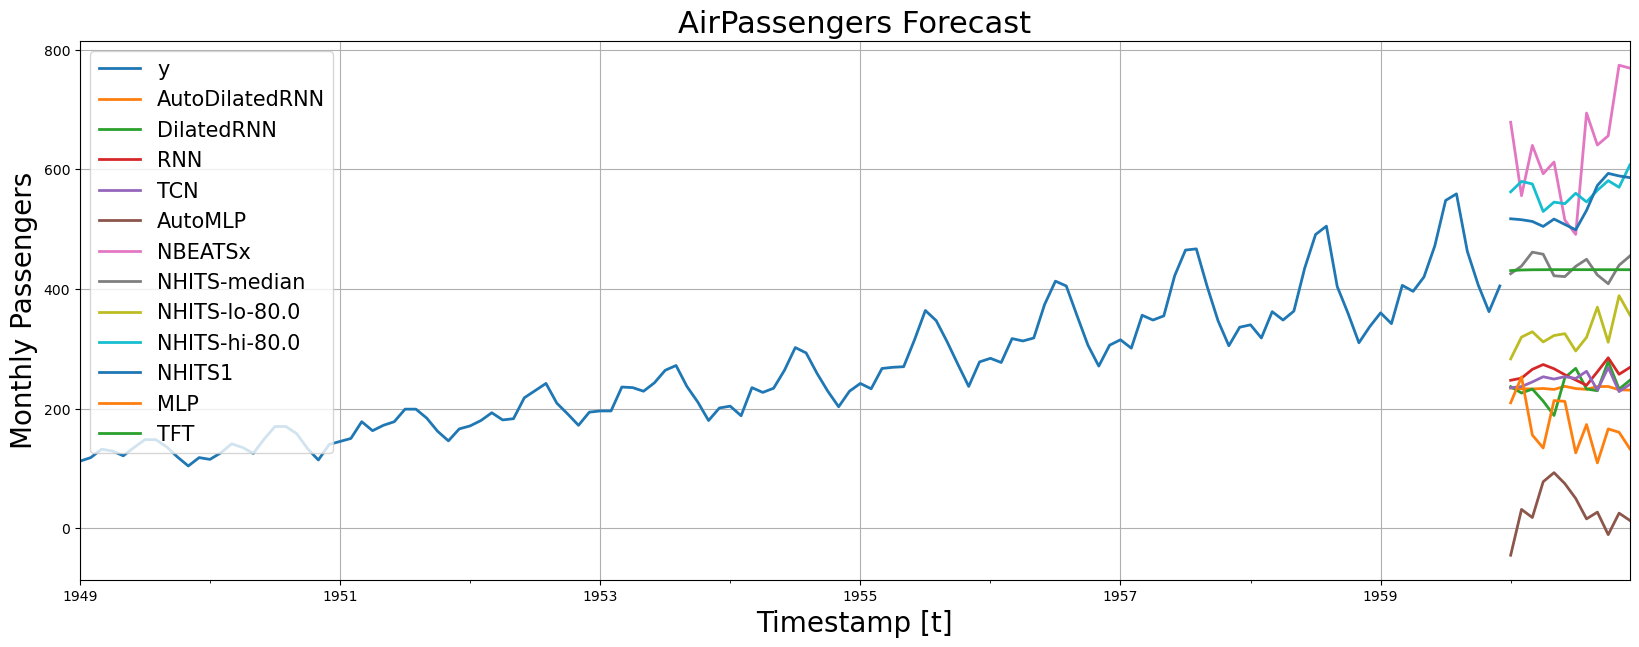

In [18]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

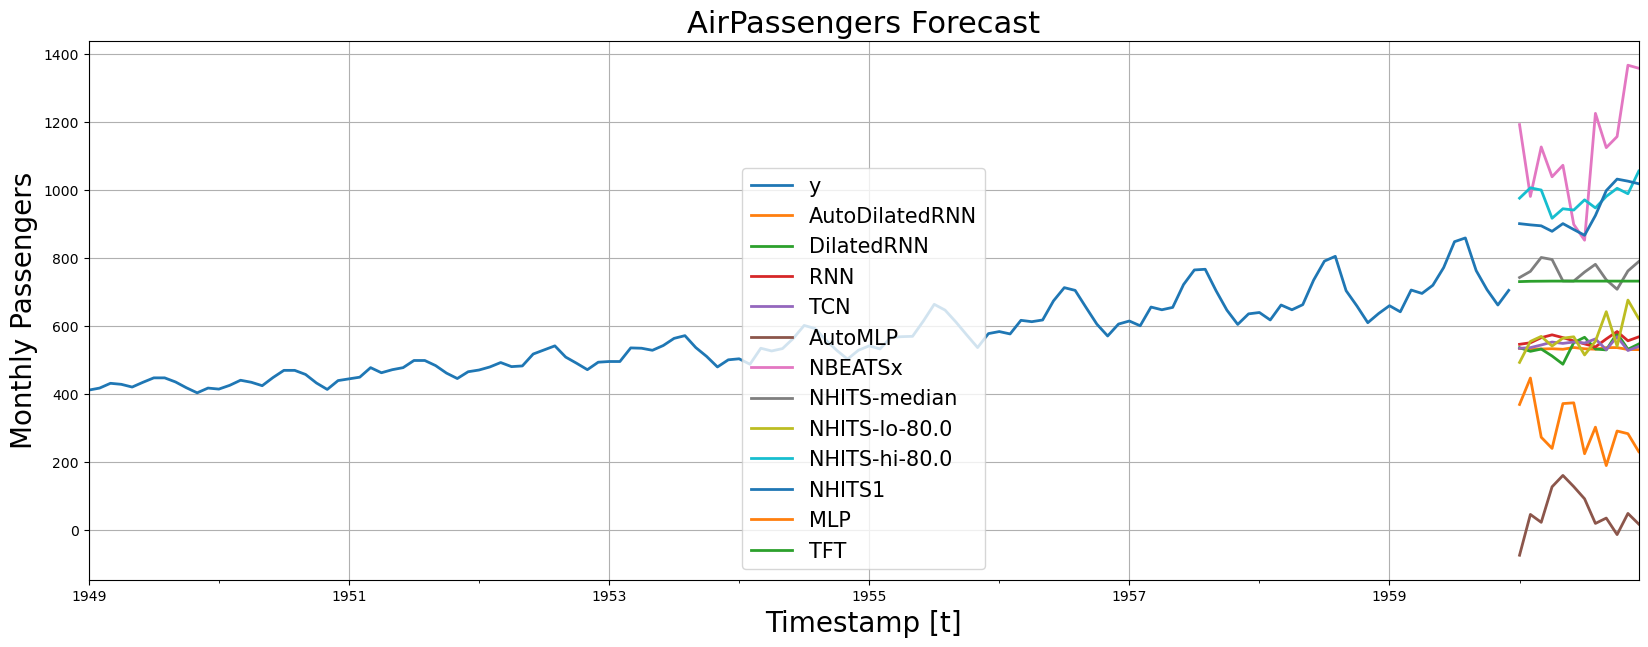

In [19]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline2'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [20]:
#| hide
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]), 
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1,
               'step_size': 1}

fcst = NeuralForecast(
    models=[
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1),
        AutoMLP(h=12, config=config, cpus=1, num_samples=1),
        NHITS(h=12, input_size=12, max_steps=1)
    ],
    freq='M'
)
cv_df = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=3, step_size=1)

(train_tune pid=21976) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=21976) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=21976)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 1


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 57.13it/s, loss=417, v_num=0, train_loss_step=417.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 68.92it/s, loss=417, v_num=0, train_loss_step=417.0, val_loss=533.0]
                                                                       
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.19it/s]


In [21]:
#| hide
#test cross validation no leakage
def test_cross_validation(df, static_df, h, test_size):
    if (test_size - h) % 1:
        raise Exception("`test_size - h` should be module `step_size`")
    
    n_windows = int((test_size - h) / 1) + 1
    Y_test_df = df.groupby('unique_id').tail(test_size)
    Y_train_df = df.drop(Y_test_df.index)
    config = {'input_size': tune.choice([12, 24]),
              'step_size': 12, 'hidden_size': 256, 'max_steps': 1, 'val_check_steps': 1}
    config_drnn = {'input_size': tune.choice([-1]), 'encoder_hidden_size': tune.choice([5, 10]),
                   'max_steps': 1, 'val_check_steps': 1}
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
            RNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            TCN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_steps=1,
                    stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_steps=1),
            TFT(h=12, input_size=24, max_steps=1, scaler_type='robust')
        ],
        freq='M'
    )
    fcst.fit(df=Y_train_df, static_df=static_df)
    Y_hat_df = fcst.predict(futr_df=Y_test_df)
    Y_hat_df = Y_hat_df.merge(Y_test_df, how='left', on=['unique_id', 'ds'])
    last_dates = Y_train_df.groupby('unique_id').tail(1)
    last_dates = last_dates[['unique_id', 'ds']].rename(columns={'ds': 'cutoff'})
    Y_hat_df = Y_hat_df.merge(last_dates, how='left', on='unique_id')
    
    #cross validation
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
            RNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            TCN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_steps=1,
                    stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_steps=1),
            TFT(h=12, input_size=24, max_steps=1, scaler_type='robust')
        ],
        freq='M'
    )
    Y_hat_df_cv = fcst.cross_validation(df, static_df=static_df, test_size=test_size, 
                                        n_windows=None)
    pd.testing.assert_frame_equal(
        Y_hat_df[Y_hat_df_cv.columns],
        Y_hat_df_cv,
        check_dtype=False
    )

In [22]:
#| hide
test_cross_validation(AirPassengersPanel, AirPassengersStatic, h=12, test_size=12)

(train_tune pid=22006) Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s] 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=22006) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=22006)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 1


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 24.45it/s, loss=427, v_num=0, train_loss_step=427.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 32.52it/s, loss=427, v_num=0, train_loss_step=427.0, val_loss=540.0]
                                                                       
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


In [23]:
#| hide
# test save and load
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]),
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1}

fcst = NeuralForecast(
    models=[
        AutoRNN(h=12, config=config_drnn, cpus=1, num_samples=2, refit_with_val=True),
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NHITS(h=12, input_size=12, max_steps=1,
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]'])
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
forecasts1 = fcst.predict(futr_df=AirPassengersPanel_test)
fcst.save(path='./examples/debug_run/', model_index=None, overwrite=True, save_dataset=True)

(train_tune pid=22045) Global seed set to 1
(train_tune pid=22044) Global seed set to 1


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 22.72it/s, loss=427, v_num=0, train_loss_step=427.0]
Validation: 0it [00:00, ?it/s]0m 
(train_tune pid=22044) 
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=22045) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 33.21it/s, loss=427, v_num=0, train_loss_step=427.0]
(train_tune pid=22044) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 30.46it/s, loss=427, v_num=0, train_loss_step=427.0, val_loss=540.0]
                                                                       
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 29.75it/s, loss=427, v_num=0, train_loss_step=427.0, val_loss=540.0]
                                                                       
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 20.79it/s, loss=427, v_num=0, train_loss_step=427.0, val_loss=540.0, train_loss_epoch=427.0]


(train_tune pid=22045) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=22045)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=22044) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=22044)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.35it/s]


In [24]:
#| hide
# test `enable_checkpointing=True` should generate chkpt
shutil.rmtree('lightning_logs')
fcst = NeuralForecast(
    models=[
        MLP(h=12, input_size=12, max_steps=100, enable_checkpointing=True),
        RNN(h=12, input_size=-1, max_steps=100, enable_checkpointing=True)
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
last_log = f"lightning_logs/{os.listdir('lightning_logs')[-1]}"
no_chkpt_found = ~np.any([file.endswith('checkpoints') for file in os.listdir(last_log)])
test_eq(no_chkpt_found, False)

Global seed set to 1
Global seed set to 1


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 16.83it/s, loss=0.249, v_num=1, train_loss_step=0.234, train_loss_epoch=0.234]


In [25]:
#| hide
# test `enable_checkpointing=False` should not generate chkpt
shutil.rmtree('lightning_logs')
fcst = NeuralForecast(
    models=[
        MLP(h=12, input_size=12, max_steps=100),
        RNN(h=12, input_size=-1, max_steps=100)
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
last_log = f"lightning_logs/{os.listdir('lightning_logs')[-1]}"
no_chkpt_found = ~np.any([file.endswith('checkpoints') for file in os.listdir(last_log)])
test_eq(no_chkpt_found, True)

Global seed set to 1
Global seed set to 1


Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 18.48it/s, loss=0.249, v_num=1, train_loss_step=0.234, train_loss_epoch=0.234]


In [26]:
#| hide
fcst2 = NeuralForecast.load(path='./examples/debug_run/')
forecasts2 = fcst2.predict(futr_df=AirPassengersPanel_test)

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]


In [27]:
#| hide
pairwise_tuples = [('AutoRNN', 'RNN'), ('DilatedRNN','DilatedRNN'), ('AutoMLP','MLP'), ('NHITS','NHITS')]
for model1, model2 in pairwise_tuples:
    np.allclose(forecasts1[model1], forecasts2[model2])